## 引入套件

In [1]:
import warnings
warnings.filterwarnings('ignore')

from keras.layers import Input, Dense, Flatten, Dropout
from keras.models import Model
from keras.regularizers import l2

import numpy as np
import pandas as pd

import random
from collections import deque
import matplotlib.pylab as plt


In [2]:
from environment import ETFEnvironment
from utils import *

## 強化學習機器人

In [3]:
class Agent:
    
    def __init__(
                     self, 
                     portfolio_size,
                     is_eval = False, 
                     allow_short = True,
                 ):
        
        self.portfolio_size = portfolio_size
        self.allow_short = allow_short
        self.input_shape = (portfolio_size, portfolio_size, )
        self.action_size = 3 # sit, buy, sell
        
        self.memory4replay = []
        self.is_eval = is_eval

        self.alpha = 0.5
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.99
        
        self.model = self._model()

    def _model(self):
        
        inputs = Input(shape=self.input_shape)        
        x = Flatten()(inputs)
        x = Dense(100, activation='elu')(x)
        x = Dropout(0.5)(x)
        x = Dense(50, activation='elu')(x)
        x = Dropout(0.5)(x)
        
        predictions = []
        for i in range(self.portfolio_size):
            asset_dense = Dense(self.action_size, activation='linear')(x)   
            predictions.append(asset_dense)
        
        model = Model(inputs=inputs, outputs=predictions)
        model.compile(optimizer='adam', loss='mse')
        return model

    def nn_pred_to_weights(self, pred, allow_short = False):

        weights = np.zeros(len(pred))
        raw_weights = np.argmax(pred, axis=-1)

        saved_min = None
        
        for e, r in enumerate(raw_weights):
            if r == 0: # sit
                weights[e] = 0
            elif r == 1: # buy
                weights[e] = np.abs(pred[e][0][r])
            else:
                weights[e] = -np.abs(pred[e][0][r])

        if not allow_short:
            weights += np.abs(np.min(weights))
            saved_min = np.abs(np.min(weights))
            saved_sum = np.sum(weights)
        else:
            saved_sum = np.sum(np.abs(weights))
            
        weights /= saved_sum
        return weights, saved_min, saved_sum
    
    def act(self, state):
        
        if not self.is_eval and random.random() <= self.epsilon:
            w = np.random.normal(0, 1, size = (self.portfolio_size, ))  
              
            saved_min = None
            
            if not self.allow_short:
                w += np.abs(np.min(w))
                saved_min = np.abs(np.min(w))
                
            saved_sum = np.sum(w)
            w /= saved_sum
            return w , saved_min, saved_sum

        pred = self.model.predict(np.expand_dims(state.values, 0))
        return self.nn_pred_to_weights(pred, self.allow_short)

    def expReplay(self, batch_size):

        def weights_to_nn_preds_with_reward(action_weights, 
                                            reward, 
                                            Q_star = np.zeros((self.portfolio_size, self.action_size))): 
            
            Q = np.zeros((self.portfolio_size, self.action_size))           
            for i in range(self.portfolio_size):
                if action_weights[i] == 0:
                    Q[i][0] = reward[i] + self.gamma * np.max(Q_star[i][0])
                elif action_weights[i] > 0:
                    Q[i][1] = reward[i] + self.gamma * np.max(Q_star[i][1])
                else:
                    Q[i][2] = reward[i] + self.gamma * np.max(Q_star[i][2])            
            return Q  
        
        def restore_Q_from_weights_and_stats(action):            
            action_weights, action_min, action_sum = action[0], action[1], action[2]
            action_weights = action_weights * action_sum          
            if action_min != None:
                action_weights = action_weights - action_min   
            return action_weights
        
        for (s, s_, action, reward, done) in self.memory4replay:
            
            action_weights = restore_Q_from_weights_and_stats(action) 
            Q_learned_value = weights_to_nn_preds_with_reward(action_weights, reward)
            s, s_ = s.values, s_.values    

            if not done:
                # reward + gamma * Q^*(s_, a_)
                Q_star = self.model.predict(np.expand_dims(s_, 0))
                Q_learned_value = weights_to_nn_preds_with_reward(action_weights, reward, np.squeeze(Q_star))  

            Q_learned_value = [xi.reshape(1, -1) for xi in Q_learned_value]
            Q_current_value = self.model.predict(np.expand_dims(s, 0))
            Q = [np.add(a * (1-self.alpha), q * self.alpha) for a, q in zip(Q_current_value, Q_learned_value)]
            
            # update current Q function with new optimal value
            self.model.fit(np.expand_dims(s, 0), Q, epochs=1, verbose=0)            
        
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

## 訓練模型

In [4]:
N_ASSETS = 138 
agent = Agent(N_ASSETS)
env = ETFEnvironment()

2021-11-09 16:12:57.667438: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
window_size = 20
episode_count = 50
batch_size = 32
rebalance_period = 20

In [29]:
for e in range(episode_count):
    
    agent.is_eval = False
    data_length = len(env.data)
    
    returns_history = []
    returns_history_equal = []
    
    rewards_history = []
    equal_rewards = []
    
    actions_to_show = []
    
    print("Episode " + str(e) + "/" + str(episode_count), 'epsilon', agent.epsilon)

    s = env.get_state(np.random.randint(window_size+1, data_length-window_size-1), window_size)
    total_profit = 0 

    for t in range(window_size, data_length, rebalance_period):

        date1 = t-rebalance_period
        
        s_ = env.get_state(t, window_size)
        action = agent.act(s_)
        
        actions_to_show.append(action[0])

        weighted_returns, reward = env.get_reward(action[0], date1, t)
        weighted_returns_equal, reward_equal = env.get_reward(
            np.ones(agent.portfolio_size) / agent.portfolio_size, date1, t)

        rewards_history.append(reward)
        equal_rewards.append(reward_equal)
        returns_history.extend(weighted_returns)
        returns_history_equal.extend(weighted_returns_equal)

        done = True if t == data_length else False
        agent.memory4replay.append((s, s_, action, reward, done))
        
        if len(agent.memory4replay) >= batch_size:
            agent.expReplay(batch_size)
            agent.memory4replay = []
            
        s = s_

    rl_result = np.array(returns_history).cumsum()
    equal_result = np.array(returns_history_equal).cumsum()

    #plt.figure(figsize = (12, 2))
    #plt.plot(rl_result, color = 'black', ls = '-')
    #plt.plot(equal_result, color = 'grey', ls = '--')
    #plt.show()
    
    #plt.figure(figsize = (12, 2))
    #for a in actions_to_show:    
    #    plt.bar(np.arange(N_ASSETS), a, color = 'grey', alpha = 0.25)
    #    plt.xticks(np.arange(N_ASSETS), env.data.columns, rotation='vertical')
    #plt.show()


Episode 0/50 epsilon 0.5989560064661611
Episode 1/50 epsilon 0.5929664464014994
Episode 2/50 epsilon 0.5929664464014994
Episode 3/50 epsilon 0.5929664464014994
Episode 4/50 epsilon 0.5870367819374844
Episode 5/50 epsilon 0.5870367819374844
Episode 6/50 epsilon 0.5870367819374844
Episode 7/50 epsilon 0.5811664141181095
Episode 8/50 epsilon 0.5811664141181095
Episode 9/50 epsilon 0.5811664141181095
Episode 10/50 epsilon 0.5811664141181095
Episode 11/50 epsilon 0.5753547499769285
Episode 12/50 epsilon 0.5753547499769285
Episode 13/50 epsilon 0.5753547499769285
Episode 14/50 epsilon 0.5696012024771592
Episode 15/50 epsilon 0.5696012024771592
Episode 16/50 epsilon 0.5696012024771592
Episode 17/50 epsilon 0.5639051904523876
Episode 18/50 epsilon 0.5639051904523876
Episode 19/50 epsilon 0.5639051904523876
Episode 20/50 epsilon 0.5582661385478638
Episode 21/50 epsilon 0.5582661385478638
Episode 22/50 epsilon 0.5582661385478638
Episode 23/50 epsilon 0.5526834771623851
Episode 24/50 epsilon 0.55

In [30]:
agent.is_eval = True

actions_equal, actions_rl = [], []
result_equal, result_rl = [], []

for t in range(window_size, len(env.data), rebalance_period):

    date1 = t-rebalance_period
    s_ = env.get_state(t, window_size)
    action = agent.act(s_)

    weighted_returns, reward = env.get_reward(action[0], date1, t)
    weighted_returns_equal, reward_equal = env.get_reward(
        np.ones(agent.portfolio_size) / agent.portfolio_size, date1, t)

    result_equal.append(weighted_returns_equal.tolist())
    actions_equal.append(np.ones(agent.portfolio_size) / agent.portfolio_size)
    
    result_rl.append(weighted_returns.tolist())
    actions_rl.append(action[0])

In [31]:
result_equal_vis = [item for sublist in result_equal for item in sublist]
result_rl_vis = [item for sublist in result_rl for item in sublist]

In [32]:
import pandas
results = pandas.DataFrame({'result_equal_vis':result_equal_vis, 
                  'result_rl_vis': result_rl_vis})
results.head()

,result_equal_vis,result_rl_vis
0,-0.012084,-0.005933
1,0.007076,-0.000036
2,0.007679,0.003557
3,0.005810,0.000628
4,-0.010321,-0.002849


## 匯出運算結果

In [33]:
results.to_csv('data/rl_result.csv')

## 評估資產配置效果

In [34]:
import pandas
df = pandas.read_csv('data/rl_result.csv', index_col = 0)
df.head()

,result_equal_vis,result_rl_vis
0,-0.012084,-0.005933
1,0.007076,-0.000036
2,0.007679,0.003557
3,0.005810,0.000628
4,-0.010321,-0.002849


<AxesSubplot:>

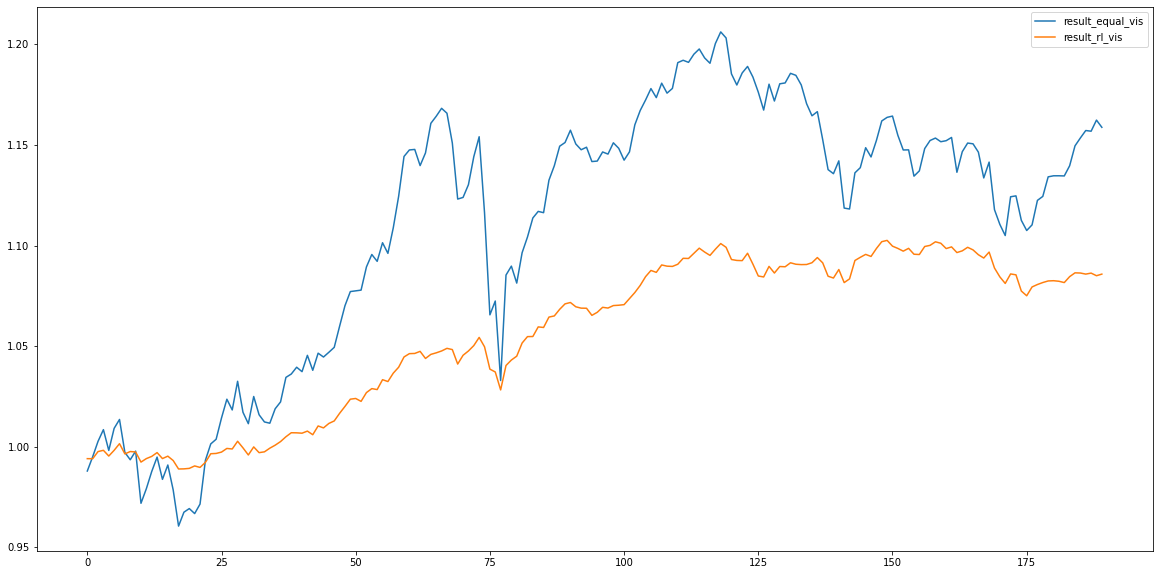

In [35]:
(df.cumsum() + 1).plot(kind = 'line', figsize = [20,10])